# Imports

In [ ]:
import json
import logging
import os
from datetime import timedelta

import pandas as pd
import requests

import helpers.hdatetime as hdateti
import helpers.hdbg as hdbg
import helpers.hpandas as hpandas
import helpers.hparquet as hparque
import helpers.hprint as hprint
import im_v2.ccxt.data.client as icdcl
import im_v2.ccxt.data.extract.exchange_class as imvcdeexcl

In [ ]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

hprint.config_notebook()

## CCXT Historical Client

In [ ]:
# Specify params.
universe_version = "v3"
resample_1min = True
root_dir = os.path.join("s3://cryptokaizen-data", "historical")
partition_mode = "by_year_month"
data_snapshot = "latest"
aws_profile = "ck"

# Initiate the client.
historical_client = icdcl.CcxtHistoricalPqByTileClient(
    universe_version,
    resample_1min,
    root_dir,
    partition_mode,
    data_snapshot=data_snapshot,
    aws_profile=aws_profile,
)

## Crypto-chassis Historical

In [ ]:
def load_crypto_chassis_ohlcv(exhange_id, currency_pair):
    r = requests.get(
        f"https://api.cryptochassis.com/v1/ohlc/{exhange_id}/{currency_pair}?startTime=0"
    )
    df = pd.read_csv(r.json()["historical"]["urls"][0]["url"], compression="gzip")
    df["time_seconds"] = df["time_seconds"].apply(
        lambda x: hdateti.convert_unix_epoch_to_timestamp(x, unit="s")
    )
    df = df.set_index("time_seconds")
    return df

# `Kucoin` case

## Example that the data is available in other sources

### `full_symbol` = kucoin::ADA_USDT

#### Load the data

In [ ]:
# Load historical data from CCXT.
full_symbols = ["kucoin::ADA_USDT"]
start_date = None
end_date = None
ada_kucoin_ccxt = historical_client.read_data(full_symbols, start_date, end_date, columns=None)
# Load historical data from crypto-chassis.
ada_kucoin_ch = load_crypto_chassis_ohlcv("kucoin", "ada-usdt")

#### Take a specific period of time - [2022-02-09 00:00, 2022-02-09 13:33]

In [ ]:
ccxt_ada_nans = ada_kucoin_ccxt.loc[
    (ada_kucoin_ccxt.index > "2022-02-09 00:00:00+00:00")
    & (ada_kucoin_ccxt.index < "2022-02-09 13:33:00+00:00")
]
chassis_ada = ada_kucoin_ch.loc[
    (ada_kucoin_ch.index > "2022-02-09 00:00:00+00:00")
    & (ada_kucoin_ch.index < "2022-02-09 13:33:00+00:00")
]
# Check that the lenght is identical.
print(
    f"Both datasets have the same length: {len(ccxt_ada_nans)==len(chassis_ada)}"
)

#### Data snapshot

In [ ]:
print("Period of NaNs in CCXT:")
display(ccxt_ada_nans)
print("Complete data in chassis:")
display(chassis_ada)

In [ ]:
print(
    f"Percentage of NaNs in CCXT data for the period: {len(ccxt_ada_nans[ccxt_ada_nans.open.isna()])*100/len(ccxt_ada_nans)}"
)
print(
    f"Percentage of NaNs in crypto-chassis data for the period: {len(chassis_ada[chassis_ada.open.isna()])*100/len(chassis_ada)}"
)

### `full_symbol` = kucoin::BTC_USDT

This full symbol has the highest coverage according to https://github.com/cryptokaizen/cmamp/issues/1750#issuecomment-1106866542

#### Load the data

In [ ]:
# Load historical data from CCXT.
full_symbols = ["kucoin::BTC_USDT"]
start_date = None
end_date = None
btc_kucoin_ccxt = historical_client.read_data(full_symbols, start_date, end_date)
# Load historical data from crypto-chassis.
btc_kucoin_ch = load_crypto_chassis_ohlcv("kucoin", "btc-usdt")

#### Take a specific period of time - a year 2021

In [ ]:
ccxt_btc = btc_kucoin_ccxt.loc[
    (btc_kucoin_ccxt.index > "2021-08-07")
    & (btc_kucoin_ccxt.index < "2021-12-31")
]
chassis_btc = btc_kucoin_ch.loc[
    (btc_kucoin_ch.index > "2021-08-07") & (btc_kucoin_ch.index < "2021-12-31")
]

In [ ]:
# From crypto-chassis docs:
# If there is a gap in "time_seconds", it means that
# the market depth snapshot at that moment is the same as the previous moment.
# It means that NaNs there are 'gaps' between timestamps.
chassis_btc["timestamp_diff"] = chassis_btc.index.to_series().diff()
# Exclude 1min gaps (means no NaNs) and calculate the num of mins in gaps (equals to num of NaNs).
chassis_btc[chassis_btc["timestamp_diff"] != "0 days 00:01:00"]
# Calculate the total rows with NaNs.
num_of_nans_chassis = chassis_btc["timestamp_diff"].sum() / timedelta(minutes=1)

In [ ]:
print(
    f"NaNs percentage in CCXT for `kucoin::BTC_USDT` for 2021: {100*len(ccxt_btc[ccxt_btc.open.isna()])/len(ccxt_btc)}"
)
print(
    f"NaNs percentage in crypto-chassis for `kucoin::BTC_USDT` for 2021: {100*num_of_nans_chassis/(len(chassis_btc)+num_of_nans_chassis)}"
)

#### Take a specific period of time - [2022-01-15 12:00, 2022-01-15 21:00]

In [ ]:
ccxt_btc2022 = btc_kucoin_ccxt.loc[
    (btc_kucoin_ccxt.index > "2022-01-15 12:00:00")
    & (btc_kucoin_ccxt.index < "2022-01-15 21:00:00")
]
chassis_btc2022 = btc_kucoin_ch.loc[
    (btc_kucoin_ch.index > "2022-01-15 12:00:00")
    & (btc_kucoin_ch.index < "2022-01-15 21:00:00")
]
print(
    f"Both datasets have the same length: {len(ccxt_btc2022)==len(chassis_btc2022)}"
)

In [ ]:
print("Period of NaNs in CCXT:")
display(ccxt_btc2022)
print("Complete data in chassis:")
display(chassis_btc2022)

### Summary

From what we can see in comparison with other data vendors, __the problem of data coverage has little to do with the initial data provider__ (i.e., `kucoin`), since the NaN data in `CCXT` is available in other providers (`crypto-chassis`)

## Look at S3

In [ ]:
# Take the previously spotted NaN sequence.
ccxt_ada_nans = ada_kucoin_ccxt.loc[
    (ada_kucoin_ccxt.index > "2022-02-01 00:00:00+00:00")
    & (ada_kucoin_ccxt.index < "2022-02-09 13:33:00+00:00")
]
ccxt_ada_nans

In [ ]:
print(
    f"Percentage of NaN data: {100*len(ccxt_ada_nans[ccxt_ada_nans.open.isna()])/len(ccxt_ada_nans)}"
)

S3 has the only file in the February for `kucoin::ADA_USDT`:

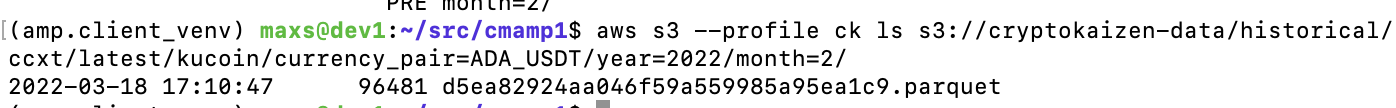

In [ ]:
file_path = "s3://cryptokaizen-data/historical/ccxt/latest/kucoin/currency_pair=ADA_USDT/year=2022/month=2/d5ea82924aa046f59a559985a95ea1c9.parquet"
pq_ada = pd.read_parquet(file_path)
pq_ada

One can notice that the data for February starts exactly from the point where NaN sequence is ending.

### Summary

The raw data doesn't have include the data for NaN sequences in client which means that with great probability, __the client doesn't distorts the raw data and it comes initially with these NaN sequences__.

# Load CCXT data using requests from CCXT

## Function

In [ ]:
def timestamp_to_datetime(timestamps):
    times = []
    for time in timestamps:
        times.append(hdateti.convert_unix_epoch_to_timestamp(time))
    return times

## Load data

## Extractor

In [ ]:
ccxt_kucoin_ada_exchange = imvcdeexcl.CcxtExchange("kucoin")
ccxt_kucoin_ada_data = ccxt_kucoin_ada_exchange.download_ohlcv_data("ADA/USDT")

In [ ]:
# Nina: data is hard to load for the whole month using CcxtExchange. Duration of downloading more than 5 hours.
currency_pair = "ADA/USDT"
start_timestamp = pd.Timestamp("2019-08-30")
end_timestamp = pd.Timestamp("2019-08-31")
sleep_time_in_secs = 20
ccxt_kucoin_ada_data = ccxt_kucoin_ada_exchange.download_ohlcv_data(
    currency_pair,
    start_timestamp=start_timestamp,
    end_timestamp=end_timestamp,
    sleep_time_in_secs=sleep_time_in_secs,
)

In [ ]:
df = ccxt_kucoin_ada_data.copy()

In [ ]:
indexes = timestamp_to_datetime(df["timestamp"])
df.set_index(pd.to_datetime(indexes), inplace=True)
df

In [ ]:
df.loc[df["volume"].isna()]

In [ ]:
# 2020
start_timestamp = pd.Timestamp("2020-01-30")
end_timestamp = pd.Timestamp("2020-01-31")
ccxt_kucoin_ada_data = ccxt_kucoin_ada_exchange.download_ohlcv_data(
    currency_pair,
    start_timestamp=start_timestamp,
    end_timestamp=end_timestamp,
    sleep_time_in_secs=sleep_time_in_secs,
)

In [ ]:
df = ccxt_kucoin_ada_data.copy()
indexes = timestamp_to_datetime(df["timestamp"])
df.set_index(pd.to_datetime(indexes), inplace=True)
df

In [ ]:
df.loc[df["volume"].isna()]

In [ ]:
# 2021
start_timestamp = pd.Timestamp("2021-12-29 23:00:00+00:00")
end_timestamp = pd.Timestamp("2021-12-30 23:59:00+00:00")
ccxt_kucoin_ada_data = ccxt_kucoin_ada_exchange.download_ohlcv_data(
    currency_pair,
    start_timestamp=start_timestamp,
    end_timestamp=end_timestamp,
    sleep_time_in_secs=sleep_time_in_secs,
)

In [ ]:
df = ccxt_kucoin_ada_data.copy()
indexes = timestamp_to_datetime(df["timestamp"])
df.set_index(pd.to_datetime(indexes), inplace=True)
df

In [ ]:
df.loc[df["volume"].isna()]

In [ ]:
_LOG.info(ccxt_kucoin_ada_data.shape)
ccxt_kucoin_ada_data.head()

### Load data using simple requests

In [ ]:
def get_url(symbol: str, start_ts: int, end_ts: int) -> str:
    url = f"https://openapi-v2.kucoin.com/api/v1/market/candles?symbol={symbol}&type=1min&startAt={start_ts}&endAt={end_ts}"
    return url

In [ ]:
symbol = "ADA-USDT"
# 2019-08-01 00:00:00 GMT+0000
start = 1564617600
# 2019-08-31 23:59:59 GMT+0000
end = 1567295999
url = get_url(symbol, start, end)
response = requests.get(url)
# check if data in response.
response.text[:100]

In [ ]:
data = json.loads(response.text)
data = data["data"]
columns = ["timestamp", "open", "high", "low", "close", "volume", "unknown_col"]
df_2019 = pd.DataFrame(data, columns=columns)
df_2019.head(3)

In [ ]:
# Data is loaded for one day (roughly) but IDK why, maybe because of some limits.
df_2019["timestamp"].sort_values()

In [ ]:
symbol = "ADA-USDT"
# 2020-01-30 23:00:00 GMT+0000
start = 1580425200
# 2020-01-31 23:59:59 GMT+0000
end = 1580515199
url = get_url(symbol, start, end)
response = requests.get(url)
# check if data in response.
response.text[:100]

In [ ]:
data_2020 = json.loads(response.text)
data_2020 = data_2020["data"]
columns = ["timestamp", "open", "high", "low", "close", "volume", "unknown_col"]
df_2020 = pd.DataFrame(data_2020, columns=columns)
_LOG.info(df_2020.shape)
df_2020.head(3)

In [ ]:
symbol = "ADA-USDT"
# 2021-12-29 23:00:00 GMT+0000
start = 1640818800
# 2021-12-30 23:59:59 GMT+0000
end = 1640908799
url = get_url(symbol, start, end)
response = requests.get(url)
# check if data in response.
response.text[:100]

In [ ]:
data_2021 = json.loads(response.text)
data_2021 = data_2021["data"]
columns = ["timestamp", "open", "high", "low", "close", "volume", "unknown_col"]
df_2021 = pd.DataFrame(data_2021, columns=columns)
_LOG.info(df_2021.shape)
df_2021.head(3)

## Set Datetime index to loaded data

In [ ]:
indexes = timestamp_to_datetime(ccxt_kucoin_ada_data["timestamp"])
ccxt_kucoin_ada_data.set_index(pd.to_datetime(indexes), inplace=True)
ccxt_kucoin_ada_data.head(2)

In [ ]:
# Tricky manipulations to create a correct timestamp to convert to datetime.
def change_timestamp(df):
    for timestamp in df["timestamp"]:
        df["timestamp"].loc[df["timestamp"] == timestamp] = f"{timestamp}000"
    return df

In [ ]:
df_2019 = change_timestamp(df_2019)
df_2019 = df_2019.convert_dtypes()
df_2019["timestamp"] = pd.to_numeric(df_2019["timestamp"])

In [ ]:
indexes = timestamp_to_datetime(df_2019["timestamp"])
df_2019.set_index(pd.to_datetime(indexes), inplace=True)
df_2019.head(2)

In [ ]:
df_2019.loc[df_2019["volume"].isna()]

In [ ]:
df_2019.loc[df_2019["volume"] == "0"]

In [ ]:
# Data of 2020-01-30 ~ 2020-01-31
df_2020 = change_timestamp(df_2020)
df_2020 = df_2020.convert_dtypes()
df_2020["timestamp"] = pd.to_numeric(df_2020["timestamp"])
indexes = timestamp_to_datetime(df_2020["timestamp"])
df_2020.set_index(pd.to_datetime(indexes), inplace=True)
df_2020.head(2)

In [ ]:
df_2020.loc[df_2020["volume"].isna()]

In [ ]:
df_2020.loc[df_2020["volume"] == "0"]

In [ ]:
# Data of 2021-12-29 ~ 2021-12-30
df_2021 = change_timestamp(df_2021)
df_2021 = df_2021.convert_dtypes()
df_2021["timestamp"] = pd.to_numeric(df_2021["timestamp"])
indexes = timestamp_to_datetime(df_2021["timestamp"])
df_2021.set_index(pd.to_datetime(indexes), inplace=True)
df_2021.head(2)

In [ ]:
use_index = True
# Refactored hpandas.drop_duplicates from CMTask1588 (not in master yet).
df_2021_no_dup = hpandas.drop_duplicates(df_2021, use_index)
df_2021_no_dup.head(3)

In [ ]:
df_2021_no_dup.shape

In [ ]:
# Non-refactored hpandas.drop_duplicates.
df_2021_no_dup = hpandas.drop_duplicates(df_2021)
_LOG.info(df_2021_no_dup.shape)
df_2021_no_dup.head(3)

Just checked it and compared with two versions of `hpandas.drop_duplicates` in case there were any duplicates.

In [ ]:
df_2021.loc[df_2021["volume"].isna()]

In [ ]:
df_2021.loc[df_2021["volume"] == "0"]

In [ ]:
df_2021.loc[df_2021.duplicated(subset=["open", "high", "low", "close", "volume"])]

## Take a specific period of time - ["2019-02-18 00:00:00+00:00"]

In [ ]:
ccxt_ada_nans = ada_kucoin_ccxt.loc[
    (ada_kucoin_ccxt.index > "2019-02-18 00:00:00+00:00")
    & (ada_kucoin_ccxt["open"].isna == True)
]
ccxt_exchange_ada = ccxt_kucoin_ada_data.loc[
    (ccxt_kucoin_ada_data.index > "2019-02-18 00:00:00+00:00")
]
# Check that the lenght is identical.
print(
    f"Both datasets have the same length: {len(ccxt_ada_nans)==len(ccxt_exchange_ada)}"
)

In [ ]:
print("Period of NaNs in CCXT:")
_LOG.info(ccxt_ada_nans.shape)
display(ccxt_ada_nans.head())
print("\n******************************************\n")
print("Complete data:")
_LOG.info(ccxt_exchange_ada.shape)
display(ccxt_exchange_ada.head())

In [ ]:
ccxt_ada_nans = ada_kucoin_ccxt.loc[
    (ada_kucoin_ccxt.index < "2019-02-18 00:00:00+00:00")
    & (ada_kucoin_ccxt["open"].isna == True)
]
ccxt_exchange_ada = ccxt_kucoin_ada_data.loc[
    (ccxt_kucoin_ada_data.index < "2019-02-18 00:00:00+00:00")
]
# Check that the lenght is identical.
print(
    f"Both datasets have the same length: {len(ccxt_ada_nans)==len(ccxt_exchange_ada)}"
)

In [ ]:
print("Period of NaNs in CCXT:")
_LOG.info(ccxt_ada_nans.shape)
display(ccxt_ada_nans.head())
print("\n******************************************\n")
print("Complete data:")
_LOG.info(ccxt_exchange_ada.shape)
display(ccxt_exchange_ada.head())

In [ ]:
print(
    f"Start: {ccxt_kucoin_ada_data.index.min()}\nEnd: {ccxt_kucoin_ada_data.index.max()}"
)

##  Take a specific period of time 2019-08-30, 2019-08-31

In [ ]:
# Data is loaded for about 24 hours.
df_2019.index.min(), df_2019.index.max()

In [ ]:
ccxt_ada_nans_2019 = ada_kucoin_ccxt.loc[
    (ada_kucoin_ccxt.index > "2019-08-30 23:00:00+00:00")
    & (ada_kucoin_ccxt.index < "2019-08-31 23:59:59+00:00")
    & (ada_kucoin_ccxt["open"].isna() == True)
]
_LOG.info(ccxt_ada_nans_2019.shape)
display(ccxt_ada_nans_2019.head(3))
_LOG.info(df_2019.shape)
display(df_2019.head(3))

In [ ]:
print(
    f"Percentage of NaN data: {100*len(ccxt_ada_nans_2019[ccxt_ada_nans_2019.open.isna()])/len(ccxt_ada_nans_2019)}"
)

##  Take a specific period of time 2020-01-30, 2020-01-31

In [ ]:
ccxt_ada_nans_2020 = ada_kucoin_ccxt.loc[ada_kucoin_ccxt["open"].isna() == True]
ccxt_ada_nans_2020.loc[ccxt_ada_nans_2020.index.year == 2020].index.month.unique()

In [ ]:
df_2020.index.min(), df_2020.index.max()

In [ ]:
ccxt_ada_nans_2020 = ada_kucoin_ccxt.loc[
    (ada_kucoin_ccxt.index > "2020-01-30 23:00:00+00:00")
    & (ada_kucoin_ccxt.index < "2020-01-31 23:59:00+00:00")
    & (ada_kucoin_ccxt["open"].isna() == True)
]
_LOG.info(ccxt_ada_nans_2020.shape)
display(ccxt_ada_nans_2020.head(3))
_LOG.info(df_2020.shape)
display(df_2020.head(3))

In [ ]:
print(
    f"Percentage of NaN data: {100*len(ccxt_ada_nans_2020[ccxt_ada_nans_2020.open.isna()])/len(ccxt_ada_nans_2020)}"
)

##  Take a specific period of time 2021-12-29, 2021-12-30

In [ ]:
ccxt_ada_nans_2021 = ada_kucoin_ccxt.loc[ada_kucoin_ccxt["open"].isna() == True]
ccxt_ada_nans_2021.loc[ccxt_ada_nans_2021.index.year == 2021].index.month.unique()

In [ ]:
df_2021.index.min(), df_2021.index.max()

In [ ]:
ccxt_ada_nans_2021 = ada_kucoin_ccxt.loc[
    (ada_kucoin_ccxt.index >= "2021-12-29 23:00:00+00:00")
    & (ada_kucoin_ccxt.index <= "2021-12-30 23:59:00+00:00")
    & (ada_kucoin_ccxt["open"].isna() == True)
]
_LOG.info(ccxt_ada_nans_2021.shape)
display(ccxt_ada_nans_2021.head(3))
_LOG.info(df_2021.shape)
display(df_2021.tail(3))

In [ ]:
# Take a look at data from s3 using hparque.from_parquet.
file_path = "s3://cryptokaizen-data/historical/ccxt/latest/kucoin"
data = hparque.from_parquet(file_path, aws_profile="ck")
data_loc = data.loc[
    (data.index >= "2021-12-29 23:00:00+00:00")
    & (data.index <= "2021-12-30 23:59:00+00:00")
    & (data["currency_pair"] == "ADA_USDT")
]
data_loc.head(3)

In [ ]:
data_loc.loc[data_loc["open"].isna()]

Data from S3 is full. Apparently data loss is related to `_read_data_for_multiple_symbols` (`CcxtHistoricalPqByTileClient` uses in `read_data` see parent class.)

In [ ]:
df_2021_nans = df_2021.loc[(df_2021["volume"] == "0")]
_LOG.info(df_2021_nans.shape)
df_2021_nans.head(3)

In [ ]:
print(
    f"Percentage of NaN data: {100*len(ccxt_ada_nans_2020[ccxt_ada_nans_2020.open.isna()])/len(ccxt_ada_nans_2020)}"
)

# Summary

## Data of 2019 and 2020 have following common pattern: `volume = 0`, columns `open`, `close`, `high`, `low` have the same value in the row. Apparently this type of data becomes NaNs. However, data of 2021 doesn't have that pattern and still has NaNs in loaded via `CCXT` client.

## Comparison of NaNs for `CCXT`, `Extractor`, `Client` shows that NaNs appear in the client.


|      |       CCXT           |             ||              Extractor  |       |           Client      |  |
|------|--------------|---------------------|-|---------------------|-----------|----------------------|-----------|
|date  | Number of NaN rows % | Total number of rows| Number of `volume=0` %| Number of NaN rows % | Total number of rows| Number of NaN rows % | Total number of rows|
|2019-08-30, 2019-08-31 |0|1500 | 97.53% | 0 | 1500 |97.07% | 1500 |
|2020-01-30, 2020-01-31| 0 |1500 | 66.93%| 0| 1500 |56.67% | 1500 |
|2021-12-29, 2021-12-30| 0 |1500|0 | 0 | 1500| 74.6% | 1500|

In [ ]:
# Data loaded with `from_parquet()`.
df1 = data_loc.copy()
df1_no_nan = df1.loc[df1["open"].isna() == False]
_LOG.info(f"df1_no_nan {df1_no_nan.shape}")
# Data loaded with `CcxtHistoricalPqByTileClient`.
df2 = ada_kucoin_ccxt.copy()
df2_nan = df2.loc[
    (ada_kucoin_ccxt.index >= "2021-12-29 23:00:00+00:00")
    & (ada_kucoin_ccxt.index <= "2021-12-30 23:59:00+00:00")
    & (ada_kucoin_ccxt["open"].isna() == True)
]
_LOG.info(f"df2_nan{df2_nan.shape}")

In [ ]:
print(
    f"% of NaNs in data loaded with `from_parquet()`: {len(df1.loc[df1['open'].isna()]) * 100 / len(df1)}"
)
print(
    f"% of NaNs in data loaded with `CcxtHistoricalPqByTileClient`: {len(df2_nan) * 100 / len(df2)}"
)

In [ ]:
df1_no_nan = df1_no_nan.drop(
    columns=["currency_pair", "year", "month", "timestamp"], axis=1
)
df1_no_nan = df1_no_nan.reset_index()
full_symbol = full_symbols * len(df1_no_nan)
df1_no_nan.insert(0, "full_symbol", full_symbol)
df1_no_nan.index.name = None
df2_nan = df2_nan.reset_index()
df2_nan.index.name = None
df3 = pd.merge(df1_no_nan, df2_nan, how="right", on=["full_symbol", "timestamp"])
_LOG.info(df3.shape)
df3.head()

In [ ]:
df1.loc[
    (df1.index >= "2021-12-29 23:00:00+00:00")
    & (df1.index <= "2021-12-30 17:39:00+00:00")
]

S3 has no data in between `2021-12-29 23:00:00+00:00` and `2021-12-30 17:39:00+00:00`. Data loaded with client (`resample_1min = True`) has NaNs in between `2021-12-29 23:00:00+00:00` and `2021-12-30 17:39:00+00:00`, so it's a resampling.

# `gateio` case

In [ ]:
# Initiate the client with resample_1min = False.
historical_client_no_resampling = icdcl.CcxtHistoricalPqByTileClient(
    universe_version,
    True,
    root_dir,
    partition_mode,
    data_snapshot=data_snapshot,
    aws_profile=aws_profile,
)

## `full_symbol = "gateio::ADA_USDT"`

In [ ]:
# Load historical data from CCXT.
full_symbols = ["gateio::ADA_USDT"]
start_date = None
end_date = None
ada_gateio_ccxt = historical_client_no_resampling.read_data(
    full_symbols, start_date, end_date, columns=None
)

In [ ]:
_LOG.info(ada_gateio_ccxt.shape)
ada_gateio_ccxt.head(3)

In [ ]:
ada_gateio_ccxt.loc[ada_gateio_ccxt["volume"].isna()]

NaNs for `full_symbol = "gateio::ADA_USDT"` and `resample_1min=False` data are absent.

In [ ]:
ada_duplicated_rows = ada_gateio_ccxt.duplicated()
ada_duplicated_rows.value_counts()

In [ ]:
ada_duplicated_index = ada_gateio_ccxt.index.duplicated()
value_counts = pd.Series(ada_duplicated_index).value_counts()
value_counts

In [ ]:
duplicated_indexes = round((value_counts[1] * 100 / len(ada_gateio_ccxt)), 6)
print(f"% of duplicated index is {duplicated_indexes}")

In [ ]:
ada_gateio_ccxt.loc[ada_duplicated_index == True]

In [ ]:
ada_gateio_ccxt.loc[ada_gateio_ccxt.index == "2021-09-12 20:02:00+00:00"]

In [ ]:
ada_gateio_ccxt.loc[ada_gateio_ccxt.index == "2021-09-18 16:22:00+00:00"]

### Values for duplicated indexes are the same accordingly. It means data isn't corrupted. % of duplicated index is 0.000775 (2 vs 258226)

## `BTC_USDT`

In [ ]:
full_symbols = ["gateio::BTC_USDT"]
start_date = None
end_date = None
btc_gateio_ccxt = historical_client_no_resampling.read_data(
    full_symbols, start_date, end_date, columns=None
)

In [ ]:
_LOG.info(btc_gateio_ccxt.shape)
btc_gateio_ccxt.head(3)

In [ ]:
btc_gateio_ccxt.loc[btc_gateio_ccxt["volume"].isna()]

Also there're no NaNs for `BTC_USDT`.

In [ ]:
btc_duplicated_index = btc_gateio_ccxt.index.duplicated()
value_counts = pd.Series(btc_duplicated_index).value_counts()
value_counts

In [ ]:
duplicated_indexes = round((value_counts[1] * 100 / len(btc_duplicated_index)), 6)
print(f"% of duplicated index is {duplicated_indexes}")

In [ ]:
btc_duplicated = btc_gateio_ccxt.loc[btc_duplicated_index == True]
btc_duplicated

In [ ]:
btc_gateio_ccxt.loc[btc_gateio_ccxt.index == "2021-09-08 08:14:00+00:0"]

In [ ]:
btc_gateio_ccxt.loc[btc_gateio_ccxt.index == "2021-06-27 23:31:00+00:00"]

### Values for duplicated indexes are identical. It means data isn't corrupted. % of duplicated index is 0.005801 (15 vs 258575)